In [1]:
%%capture
!pip install k-wave-python

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D
from kwave.ksensor import kSensor
from kwave.ktransducer import kWaveTransducerSimple, NotATransducer
from kwave.kWaveSimulation import SimulationOptions

from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.dotdictionary import dotdict
from kwave.utils.filters import spect
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.plot import voxel_plot
from kwave.utils.signals import tone_burst

/home/gordon/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# simulation settings
DATA_CAST = 'single'
# set to 'xy' or 'xz' to generate the beam pattern in different planes
MASK_PLANE= 'xy'
# set to true to compute the rms or peak beam patterns, set to false to compute the harmonic beam patterns
USE_STATISTICS= True

# define the grid
PML_X_SIZE = 20
PML_Y_SIZE = 10
PML_Z_SIZE = 10
Nx = 128 - 2*PML_X_SIZE
Ny = 128 - 2*PML_Y_SIZE
Nz = 64 - 2*PML_Z_SIZE
x = 40e-3
dx = x/Nx
dy = dx
dz = dx

kgrid = kWaveGrid([Nx, Ny, Nz], [dx, dy, dz])

In [3]:
%%capture
# define the medium
medium = kWaveMedium(sound_speed=1540,
                     density=1000,
                     alpha_coeff=0.75,
                     alpha_power=1.5,
                     BonA=6)

# create the time array - using a time == time to travel the hypot of the grid
t_end = np.sqrt(kgrid.x_size ** 2 + kgrid.y_size ** 2) / medium.sound_speed
kgrid.makeTime(medium.sound_speed, t_end=t_end)

In [4]:
# define the input signal
source_strength = 1e6
tone_burst_freq = 0.5e6
tone_burst_cycles = 4
input_signal = tone_burst(1/kgrid.dt, tone_burst_freq, tone_burst_cycles)
input_signal = (source_strength/ (medium.sound_speed * medium.density)) * input_signal


In [5]:
# define the transducer
transducer = dotdict()
transducer.number_elements = 32
transducer.element_width = 1
transducer.element_length = 12
transducer.element_spacing = 0
transducer.radius = np.inf

# calculate the width of the transducer in grid points
transducer_width = transducer.number_elements * transducer.element_width + (transducer.number_elements - 1) * transducer.element_spacing

# use this to position the transducer in the middle of the computational grid
transducer.position = np.round([1, Ny / 2 - transducer_width / 2, Nz / 2 - transducer.element_length / 2])
transducer = kWaveTransducerSimple(kgrid, **transducer)

In [6]:
not_transducer = dotdict()
not_transducer.sound_speed = medium.sound_speed  # sound speed [m/s]
not_transducer.focus_distance = 20e-3  # focus distance [m]
not_transducer.elevation_focus_distance = 19e-3  # focus distance in the elevation plane [m]
not_transducer.steering_angle = 0  # steering angle [degrees]
not_transducer.transmit_apodization = "Rectangular"
not_transducer.receive_apodization = "Rectangular"
not_transducer.active_elements = np.ones((transducer.number_elements, 1))
not_transducer.input_signal = input_signal

not_transducer = NotATransducer(transducer, kgrid, **not_transducer)

In [7]:
sensor_mask = np.zeros((Nx, Ny, Nz))

if MASK_PLANE == 'xy':    
    sensor_mask[:, :, Nz//2] = 1
    # store y axis properties        
    Nj = Ny
    j_vec = kgrid.y_vec
    j_label = 'y'
elif MASK_PLANE == 'xz':
    sensor_mask[:, Ny//2, :] = 1
    # store z axis properties
    Nj = Nz
    j_vec = kgrid.z_vec
    j_label = 'z'

In [8]:
sensor = kSensor(sensor_mask)
if USE_STATISTICS:
    sensor.record = ["p", "p_rms", "p_max"]

simulation_options = SimulationOptions(
    pml_inside=False,
    pml_size=Vector([PML_X_SIZE, PML_Y_SIZE, PML_Z_SIZE]),
    data_cast=DATA_CAST,
    save_to_disk=True,
)

if not USE_STATISTICS:
    simulation_options.stream_to_disk = "harmonic_data.h5"

execution_options = SimulationExecutionOptions(is_gpu_simulation=True)

sensor_data = kspaceFirstOrder3D(
    medium=medium,
    kgrid=kgrid,
    source=not_transducer,
    sensor=sensor,
    simulation_options=simulation_options,
    execution_options=execution_options,
)

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                             NVIDIA RTX A4000 │
│ Number of CPU threads:                                     20 │
│ Processor name:           12th Gen Intel(R) Core(TM) i7-12700 │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             128 x 128 x 64 │
│ Medium type:                                               3D │
│ Simulation time steps:                                    465 │
├───────────────────────────────────────────────────────────────┤
│         

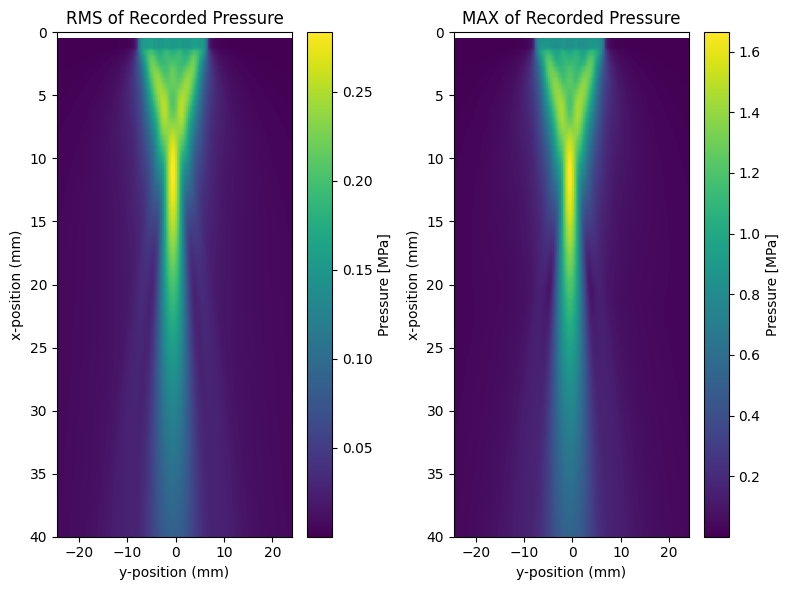

In [9]:
fig, axes = plt.subplots(1,2)
fig.set_figwidth(8)
fig.set_figheight(6)

for ind, measures in enumerate(sensor.record[1:]):    
    im1 = axes[ind].imshow(sensor_data[measures].reshape([Nj,Nx]).T * 1e-6, extent=[min(j_vec * 1e3), max(j_vec * 1e3), min((kgrid.x_vec - min(kgrid.x_vec)) * 1e3), max((kgrid.x_vec - min(kgrid.x_vec)) * 1e3)], aspect='auto')
    axes[ind].set_xlabel('y-position (mm)')
    axes[ind].set_ylabel('x-position (mm)')
    title_text = f"{str.upper(measures.split('_')[1])} of Recorded Pressure"
    axes[ind].set_title(title_text)
    axes[ind].set_yticks(axes[ind].get_yticks().tolist())
    axes[ind].set_yticklabels(axes[ind].get_yticklabels()[::-1])
    fig.colorbar(im1, label= 'Pressure [MPa]', orientation='vertical')

plt.tight_layout()
plt.show()

In [10]:
from scipy import signal

# Compute the amplitude spectrum
def spect(data, fs, dim):
    # Assuming 'spect' function is similar to MATLAB's spectrogram
    f, t, Sxx = signal.spectrogram(data, fs, axis=dim)
    amp_spect = np.abs(Sxx)
    return f, amp_spect

In [11]:
from kwave.utils.math import find_closest

sensor_data_array = np.reshape(sensor_data["p"], [kgrid.Nt, Nj, Nx])
# compute the amplitude spectrum
[freq, amp_spect] = spect(sensor_data_array, 1/kgrid.dt, dim=0)

# compute the index at which the source frequency and its harmonics occur
[f1_value, f1_index] = find_closest(freq, tone_burst_freq)
[f2_value, f2_index] = find_closest(freq, 2 * tone_burst_freq)

# extract the amplitude at the source frequency and store
beam_pattern_f1 = np.squeeze(amp_spect[f1_index, :, :])

# extract the amplitude at the second harmonic and store
beam_pattern_f2 = np.squeeze(amp_spect[f2_index, :, :])

# extract the integral of the total amplitude spectrum
beam_pattern_total = np.squeeze(np.sum(amp_spect, axis=0))


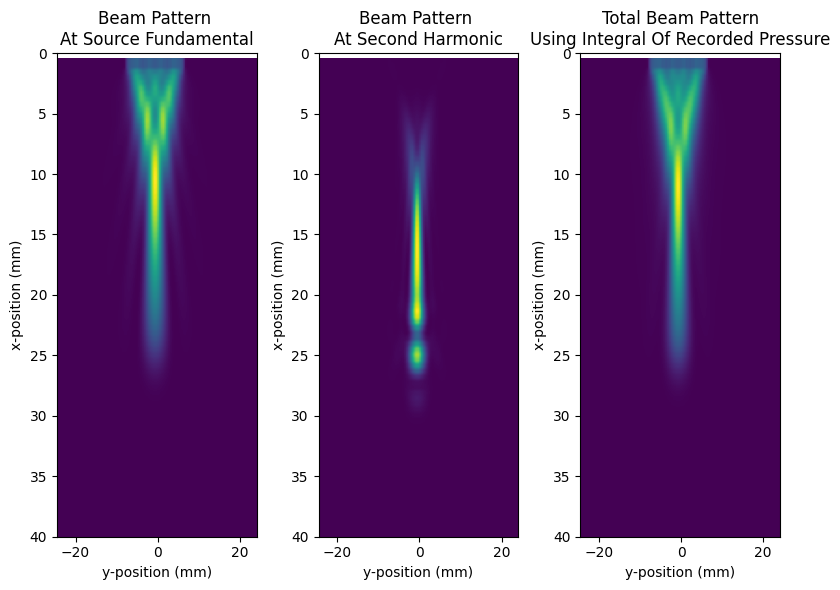

In [12]:
fig, axes = plt.subplots(1,3)
fig.set_figwidth(8)
fig.set_figheight(6)

for ind, measures in enumerate([beam_pattern_f1, beam_pattern_f2, beam_pattern_total]):
    im1 = axes[ind].imshow(np.squeeze(measures).T * 1e-6, extent=[min(j_vec * 1e3), max(j_vec * 1e3), min((kgrid.x_vec - min(kgrid.x_vec)) * 1e3), max((kgrid.x_vec - min(kgrid.x_vec)) * 1e3)], aspect='auto')
    axes[ind].set_xlabel('y-position (mm)')
    axes[ind].set_ylabel('x-position (mm)')
    
    axes[ind].set_title(title_text)
    axes[ind].set_yticks(axes[ind].get_yticks().tolist())
    axes[ind].set_yticklabels(axes[ind].get_yticklabels()[::-1])

axes[0].set_title('Beam Pattern \nAt Source Fundamental')
axes[1].set_title('Beam Pattern \nAt Second Harmonic')
axes[2].set_title('Total Beam Pattern\nUsing Integral Of Recorded Pressure')

plt.tight_layout()
plt.show()

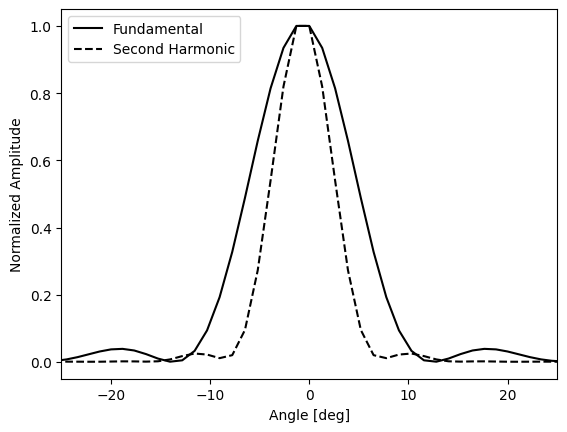

In [13]:
# Compute the directivity at each of the harmonics
directivity_f1 = beam_pattern_f1[:, round(not_transducer.focus_distance / dx)]
directivity_f2 = beam_pattern_f2[:, round(not_transducer.focus_distance / dx)]

# Normalize the directivity
directivity_f1 /= np.max(directivity_f1)
directivity_f2 /= np.max(directivity_f2)

# Compute relative angles from the transducer
if MASK_PLANE == 'xy':
    horz_axis = ((np.arange(Ny) + 1) - Ny/2) * dy
else:
    horz_axis = ((np.arange(Nz) + 1) - Nz/2) * dz

angles = 180 * np.arctan2(horz_axis, not_transducer.focus_distance) / np.pi

# Plot the directivity
plt.figure()
plt.plot(angles, directivity_f1, 'k-', label='Fundamental')
plt.plot(angles, directivity_f2, 'k--', label='Second Harmonic')
plt.axis('tight')
plt.xlabel('Angle [deg]')
plt.ylabel('Normalized Amplitude')
plt.legend(loc=2)
plt.xlim([-25,25])
plt.show()